In [1]:
import os, sys
sys.path.append("..")

## Statistical bias

In [6]:
import os
import torch
import random
import string
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils.loading import load_experiment


def get_encodings(model_dict, idxs, task_num=2):
    try:
        data_path = model_dict['data_path']
    except KeyError:
        data_path = None
    dataset, model, config = load_experiment(model_dict['config'], model_dict['ckpt'], data_path=data_path)
    X, y = dataset[idxs]
    y = y.detach().numpy()
    if task_num=='BottomBias':
        condition = y[:,1] > 6
    elif task_num=='AlignBias':
        condition = y[:,0] == y[:,1]
    y = np.where(condition, 1, 0)
    
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')

    model.to(device)
    model.eval()
    mu, logvar = model.encode(X.to(device))
    #Z = model.reparameterize(mu, logvar).detach().numpy()
    mu = mu.cpu().detach().numpy()
    # logvar = logvar.detach().numpy()
    #Z = np.concatenate([mu, logvar], axis=1)
    return mu, y

def compute_dissimilarity_m(idxs, enc, **kwargs):
    l = enc.shape[1]
    df = pd.DataFrame(enc, columns=[f'z{i}' for i in range(l)])
    df['idx'] = idxs
    df.set_index('idx', inplace=True)
    return .5 * (1 - df.T.corr())

def compute_dissimilarity_m1(idxs, enc, **kwargs):
    return pd.DataFrame(data=pairwise_distances(enc), columns=idxs, index=idxs)


def get_embeddings(diss_m, n_components=2, **kwargs):
    embedding = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42, **kwargs)
    out_ = embedding.fit_transform(diss_m)
    return out_

def get_idx2label(row):
    return f'{row[169]},{row[170]}' 

#### select images

In [8]:
data = pd.read_csv('../data/mazes_200k_2corridors_13x13.csv', header=None)
data = data.iloc[180_000:]
data['diff'] = data.iloc[:,169] - data.iloc[:,170]
#data = data.sort_values(by=['diff'])
n_imgs = 1500
idxs = data.sample(n_imgs).index
selected_idxs = [
    185_044, #0,12
    199_915, #2,10
    194_158, #4,8
    189_971, #6,6
    190_889, #8,4
    187_869, #10,2
    193_280, #12,0
    191126, #0,0
    185419, #2,2
    198997, #10,10
    197722, #12,12
    195734, #2,4
    194955, #4,2
    198524, #8,10
    185387, #10,8
    198185, #6,12
    192299, #6,0
    191412, #12,6
    188274, #0,6
    #185250, #6,4
    #196000, #6,8
    190549, #1,5
    190769, #5,1
    186536, #7,11
    188431, #11,7
]
idxs = idxs.union(selected_idxs)
data = data.loc[idxs].sort_values(by=['diff'])
idxs = data.index
idx2label = data.apply(get_idx2label, axis=1).to_dict()

In [9]:
reidxs = {idx: i for i, idx in enumerate(idxs)}
reidx2label = {reidxs[idx]: idx2label[idx] for idx in idxs}
selected_reidxs = [reidxs[selected_idx] for selected_idx in selected_idxs]


# idx to be annotated in the scatter plot
idx_toLabel = []#list(range(0, n_imgs, 50))
idx_toLabel.extend(selected_reidxs)

In [4]:
#data[(data.iloc[:,169] == 11)&(data.iloc[:,170] == 7)]

#### select models

In [1]:
models = {

    'BottomBias':{
        'base_high': {
            'config': 'logs/BetaVAE_Unbiased_2Corridors/max_c_10/hparams.yaml', 
            'ckpt': 'logs/BetaVAE_Unbiased_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'distorted_high': {
            'config': 'logs/BetaVAE_BottomBiasL2000R260_2Corridors/max_c_10/hparams.yaml',
            'data_path': 'data/mazes_200k_2corridors_13x13.csv',
            'ckpt': 'logs/BetaVAE_BottomBiasL2000R260_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'base_low': {
            'config': 'logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/hparams.yaml',
            'ckpt': 'logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
        'distorted_low': {
            'config': 'logs/BetaVAE_BottomBiasL2000R260_2Corridors/max_c_0.3/hparams.yaml',
            'data_path': 'data/mazes_200k_2corridors_13x13.csv',
            'ckpt': 'logs/BetaVAE_BottomBiasL2000R260_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
    },
    
    'AlignBias':{
        'base_high': {
            'config': 'logs/BetaVAE_Unbiased_2Corridors/max_c_10/hparams.yaml', 
            #'data_path': 'data/mazes_85k_2corridors_AlignedBias3000vs300.csv',
            'ckpt': 'logs/BetaVAE_Unbiased_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'distorted_high': {
            'config': 'logs/BetaVAE_AlignBias3000vs300_2Corridors/max_c_10/hparams.yaml',
            'data_path': 'data/mazes_200k_2corridors_13x13.csv',
            'ckpt': 'logs/BetaVAE_AlignBias3000vs300_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'base_low': {
            'config': 'logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/hparams.yaml',
            #'data_path': 'data/mazes_85k_2corridors_AlignedBias3000vs300.csv',
            'ckpt': 'logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
        'distorted_low': {
            'config': 'logs/BetaVAE_AlignBias3000vs300_2Corridors/max_c_0.3/hparams.yaml',
            'data_path': 'data/mazes_200k_2corridors_13x13.csv',
            'ckpt': 'logs/BetaVAE_AlignBias3000vs300_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
    },
}

#### plot

In [23]:
def plot_diss_m(diss_m, title, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))
    else:
        fig = None
    #ax.set_title(title)
    sns.heatmap(diss_m, ax=ax, annot=False, cmap='summer_r', xticklabels=False, yticklabels=False, **kwargs)
    return fig, ax

def plot_embeddings(emb, y, idx_toLabel, reidx2label, title, palette='Pastel2', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    else:
        fig = None
    #ax.set_title(title)
    sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=y, palette=palette, ax=ax, s=120)
    #ax.set_xticks([])
    #ax.set_yticks([])
    eps = 0.01
    for i in idx_toLabel:
        txt = reidx2label[i]
        ax.annotate(txt, (emb[i,0]+eps, emb[i,1]), size=17)
        ax.scatter(x=emb[i,0], y=emb[i,1], facecolor='none', edgecolor='black', s=120)
    return fig, ax

def plot_embeddings_3d(emb, y, idx_toLabel, reidx2label, title, ax):
    fig = None

    ax.scatter(emb[:,0], emb[:,1], emb[:,2], c=y, s=50, cmap='Pastel2')
    for i in idx_toLabel:
        txt = reidx2label[i]
        ax.text(emb[i,0], emb[i,1], emb[i,2], txt, size=17)
        ax.scatter(emb[i,0], emb[i,1], emb[i,2], facecolor='none', edgecolor='black', s=50)
        
    return fig, ax

def save_fig(in_fig, out_file, **kwargs):
    in_fig.savefig(out_file, bbox_inches='tight', pad_inches=0.1, **kwargs)
    
def get_fig_name(parent_dir, model_name, plot_type):
    """
    parent_dir : eucl_diss | corr_diss
    plot_type : dissM | emb
    """
    _, _, task, diss_metric = parent_dir.split('/')
    model_type, capacity = model_name.split('_')
    filename = f'{diss_metric[:4]}_t{task[-1]}_{model_type}_{capacity}_{plot_type}.png'
    out_dir = os.path.join(parent_dir, model_type, capacity)
    os.makedirs(out_dir, exist_ok=True)
    return os.path.join(out_dir, filename)

### IMG FOR PAPER

/tmp/ipykernel_1281077/3645978417.py:42: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



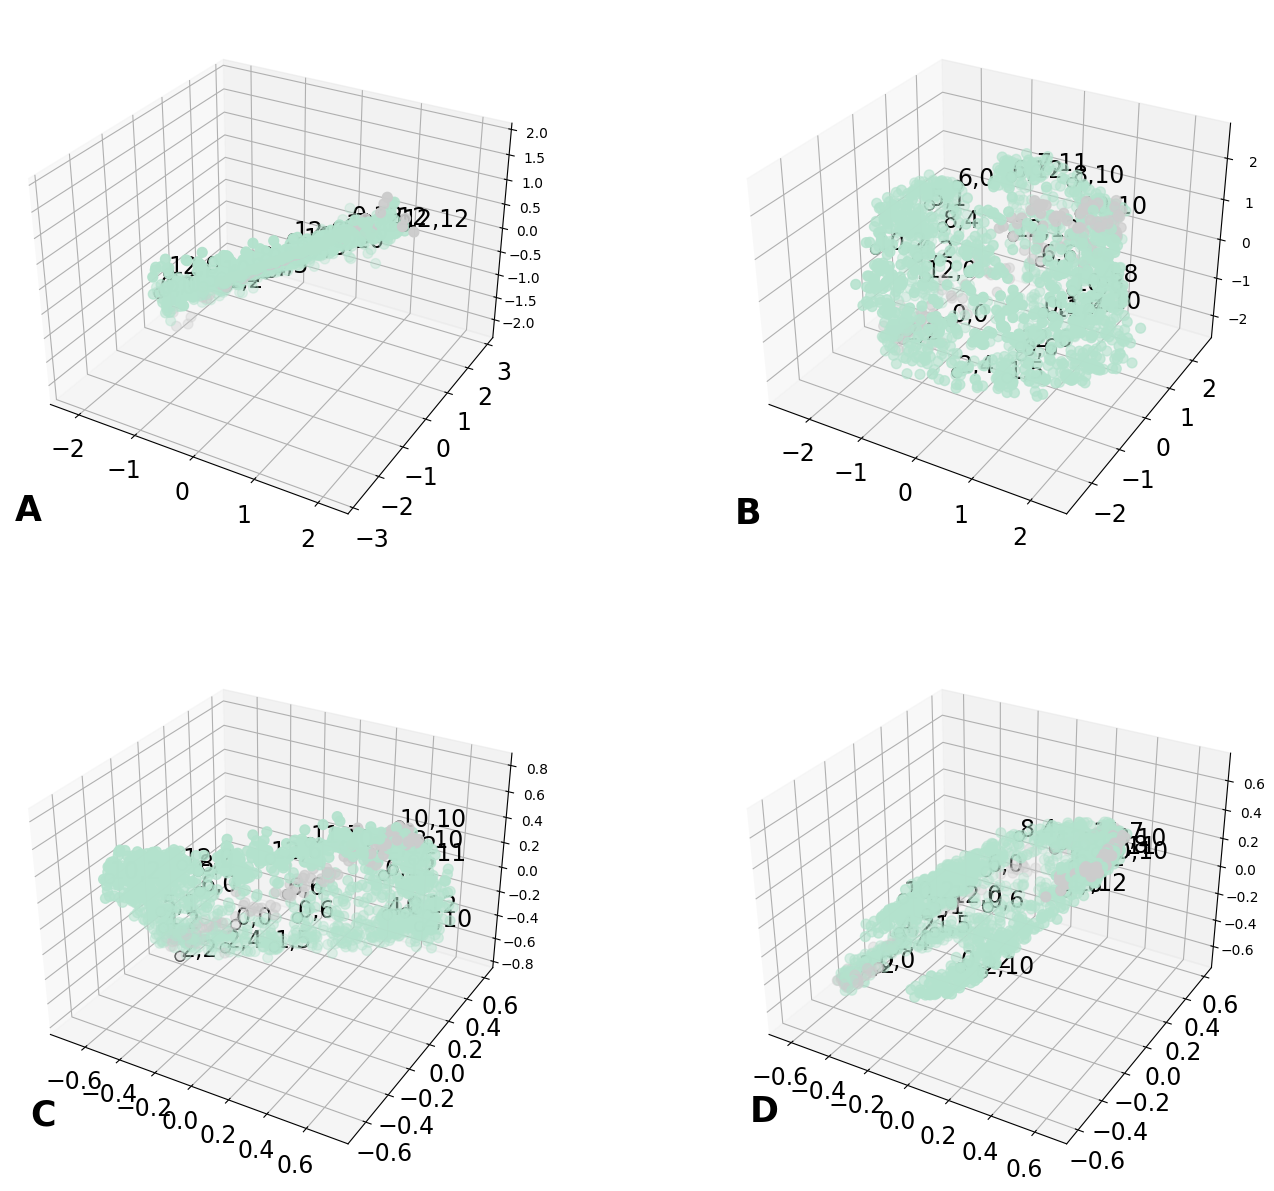

In [24]:
np.random.seed(42)
random.seed(42)
    
task = 'AlignBias'

fig, axs = plt.subplots(2, 2, figsize=(17, 15), subplot_kw={'projection': '3d'})
axs = axs.flatten()
i = 0

for model_name, model_dict in models[task].items():
    
    Z, y = get_encodings(model_dict, idxs, task_num=task)
    diss_m = compute_dissimilarity_m1(idxs, Z)
    emb = get_embeddings(diss_m, n_init=1, n_components=3)

    #fig, ax = plot_diss_m(diss_m= diss_m, title=f'{model_name}', vmin=0, vmax=6)

    if i in []:
        new_emb = emb.copy()
        new_emb[:,0] = emb[:,1]
        new_emb[:,1] = - emb[:,0]
        emb = new_emb

    # set 3d projection for ax
    axs[i].set_proj_type('persp', focal_length=0.5)  
    _, _ = plot_embeddings_3d(emb=emb, y=y, idx_toLabel=idx_toLabel, reidx2label=reidx2label, title=f'{model_name}', ax=axs[i])


    # increase font size for labels
    for item in axs[i].get_yticklabels() + axs[i].get_xticklabels():# + axs[i].get_legend().get_texts():
        item.set_fontsize(17)

    #write a bold letter on every plot
    axs[i].text(0, 1.01, 1, string.ascii_uppercase[i], transform=axs[i].transAxes, size=25, weight='bold')


    handles, labels = axs[0].get_legend_handles_labels()

    i += 1


fig.tight_layout()
fig.show()


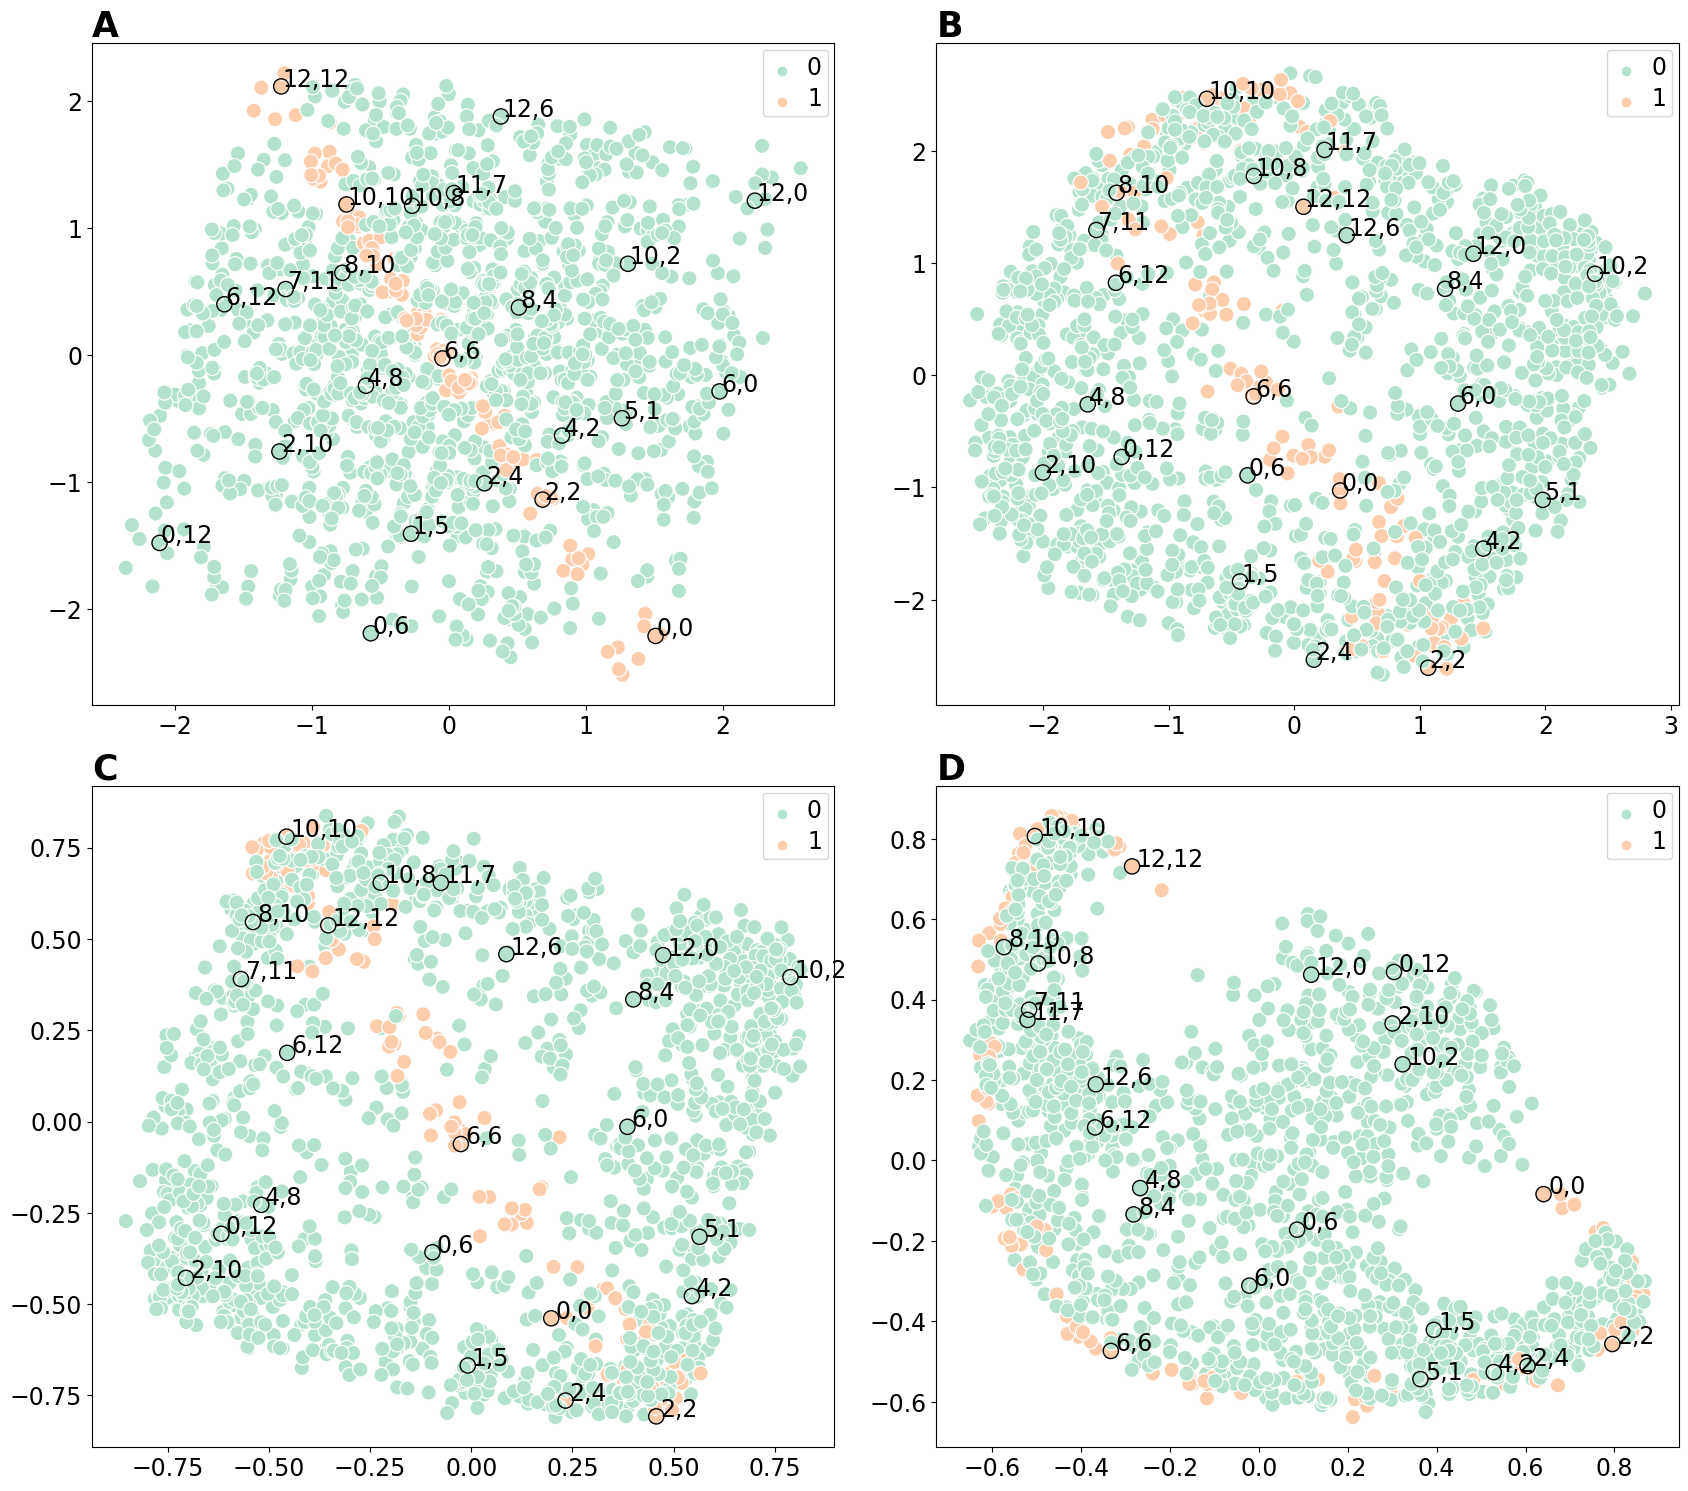

In [16]:
np.random.seed(42)
random.seed(42)
    
task = 'AlignBias'

fig, axs = plt.subplots(2, 2, figsize=(17, 15))
axs = axs.flatten()
i = 0

for model_name, model_dict in models[task].items():
    
    Z, y = get_encodings(model_dict, idxs, task_num=task)
    diss_m = compute_dissimilarity_m1(idxs, Z)
    emb = get_embeddings(diss_m, n_init=1)

    #fig, ax = plot_diss_m(diss_m= diss_m, title=f'{model_name}', vmin=0, vmax=6)

    if i in []:
        new_emb = emb.copy()
        new_emb[:,0] = emb[:,1]
        new_emb[:,1] = - emb[:,0]
        emb = new_emb

    _, _ = plot_embeddings(emb=emb, y=y, idx_toLabel=idx_toLabel, reidx2label=reidx2label, title=f'{model_name}', ax=axs[i])


    # increase font size for labels
    for item in axs[i].get_yticklabels() + axs[i].get_xticklabels() + axs[i].get_legend().get_texts():
        item.set_fontsize(17)

    #write a bold letter on every plot
    axs[i].text(0, 1.01, string.ascii_uppercase[i], transform=axs[i].transAxes, size=25, weight='bold')


    handles, labels = axs[0].get_legend_handles_labels()

    i += 1


fig.tight_layout()
fig.show()


In [ ]:
fig.savefig(f"imgs/for_paper/stat_bias/eucl_emb_{task}.pdf", format='pdf')

### 3D images

In [11]:
#plot 3d points using plotly
import plotly.graph_objects as go

np.random.seed(42)
random.seed(42)

task = 'AlignBias'
#parent_dir = f'imgs/clf_bias/{task}/corr_diss'

model_name = 'distorted_low'
model_dict = models[task][model_name]

Z, y = get_encodings(model_dict, idxs, task_num=task)
diss_m = compute_dissimilarity_m1(idxs, Z)
emb = get_embeddings(diss_m, n_components=3, n_init=1)

In [12]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure(data=[go.Scatter3d(
    x=emb[:,0],
    y=emb[:,1],
    z=emb[:,2],
    mode='markers',
    text=list(reidx2label.values()),
    marker=dict(
        size=4,
        color=y,                # set color to an array/list of desired values
        colorscale=px.colors.qualitative.Vivid_r,
        line=dict(
                color='lightgrey',
                width=0.01,
        ),
        opacity=0.8
    )
)])
# increase fig sizze
fig.update_layout(
    width=700,
    height=700,
)
fig.show()

## Tuning Curves


In [2]:
models = {

    'task0':{
        'base_high': {
            'config': '../logs/BetaVAE_Unbiased_2Corridors/max_c_10/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_Unbiased_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'distorted_high': {
            'config': '../logs/BetaVAE_CLF_task0_vaefirst/max_c_10/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_CLF_task0_vaefirst/max_c_10/checkpoints/last.ckpt'
        },
        'base_low': {
            'config': '../logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
        'distorted_low': {
            'config': '../logs/BetaVAE_CLF_task0_vaefirst/max_c_0.3/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_CLF_task0_vaefirst/max_c_0.3/checkpoints/last.ckpt'
        },
    },

    'task1':{
        'base_high': {
            'config': '../logs/BetaVAE_Unbiased_2Corridors/max_c_10/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_Unbiased_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'distorted_high': {
            'config': '../logs/BetaVAE_CLF_task1/max_c_10/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_CLF_task1/max_c_10/checkpoints/last.ckpt'
        },
        'base_low': {
            'config': '../logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
        'distorted_low': {
            'config': '../logs/BetaVAE_CLF_task1/max_c_0.3/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_CLF_task1/max_c_0.3/checkpoints/last.ckpt'
        },
    },

    'task2':{
        'base_high': {
            'config': '../logs/BetaVAE_Unbiased_2Corridors/max_c_10/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_Unbiased_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'distorted_high': {
            'config': '../logs/BetaVAE_CLF_task2/max_c_10/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_CLF_task2/max_c_10/checkpoints/last.ckpt'
        },
        'base_low': {
            'config': '../logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
        'distorted_low': {
            'config': '../logs/BetaVAE_CLF_task2/max_c_0.3/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_CLF_task2/max_c_0.3/checkpoints/last.ckpt'
        },
    },

    'task3':{
        'base_high': {
            'config': '../logs/BetaVAE_Unbiased_2Corridors/max_c_10/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_Unbiased_2Corridors/max_c_10/checkpoints/last.ckpt'
        },
        'distorted_high': {
            'config': '../logs/BetaVAE_CLF_task3/max_c_10/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_CLF_task3/max_c_10/checkpoints/last.ckpt'
        },
        'base_low': {
            'config': '../logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_Unbiased_2Corridors/max_c_0.3/checkpoints/last.ckpt'
        },
        'distorted_low': {
            'config': '../logs/BetaVAE_CLF_task3/max_c_0.3/hparams.yaml',
            'data_path': '../data/mazes_200k_2corridors_13x13.csv',
            'ckpt': '../logs/BetaVAE_CLF_task3/max_c_0.3/checkpoints/last.ckpt'
        },  
    },
}

In [3]:
import os
import torch
import random
import string
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils.loading import load_experiment


def get_encodings(model_dict, idxs, task_num=2):
    try:
        data_path = model_dict['data_path']
    except KeyError:
        data_path = None
    dataset, model, config = load_experiment(model_dict['config'], model_dict['ckpt'], data_path=data_path)
    X, y = dataset[idxs]
    y = y.detach().numpy()
    
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')

    model.to(device)
    model.eval()
    mu, logvar = model.encode(X.to(device))
    #Z = model.reparameterize(mu, logvar).detach().numpy()
    mu = mu.cpu().detach().numpy()
    # logvar = logvar.detach().numpy()
    #Z = np.concatenate([mu, logvar], axis=1)
    return mu, y

def compute_dissimilarity_m(idxs, enc, **kwargs):
    l = enc.shape[1]
    df = pd.DataFrame(enc, columns=[f'z{i}' for i in range(l)])
    df['idx'] = idxs
    df.set_index('idx', inplace=True)
    return .5 * (1 - df.T.corr())

def compute_dissimilarity_m1(idxs, enc, **kwargs):
    return pd.DataFrame(data=pairwise_distances(enc), columns=idxs, index=idxs)


def get_embeddings(diss_m, n_components=2, **kwargs):
    embedding = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42, **kwargs)
    out_ = embedding.fit_transform(diss_m)
    return out_

def get_idx2label(row):
    return f'{row[169]},{row[170]}' 

In [4]:
data = pd.read_csv('../data/mazes_200k_2corridors_13x13.csv', header=None)
data = data.iloc[180_000:]
data['diff'] = data.iloc[:,169] - data.iloc[:,170]
#data = data.sort_values(by=['diff'])
n_imgs = 1500
idxs = data.sample(n_imgs).index
selected_idxs = [
    185_044, #0,12
    199_915, #2,10
    194_158, #4,8
    189_971, #6,6
    190_889, #8,4
    187_869, #10,2
    193_280, #12,0
    191126, #0,0
    185419, #2,2
    198997, #10,10
    197722, #12,12
    195734, #2,4
    194955, #4,2
    198524, #8,10
    185387, #10,8
    198185, #6,12
    192299, #6,0
    191412, #12,6
    188274, #0,6
    #185250, #6,4
    #196000, #6,8
    190549, #1,5
    190769, #5,1
    186536, #7,11
    188431, #11,7
]
idxs = idxs.union(selected_idxs)
data = data.loc[idxs].sort_values(by=['diff'])
idxs = data.index
idx2label = data.apply(get_idx2label, axis=1).to_dict()

/home/leo/.python-envs/bvae-env/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


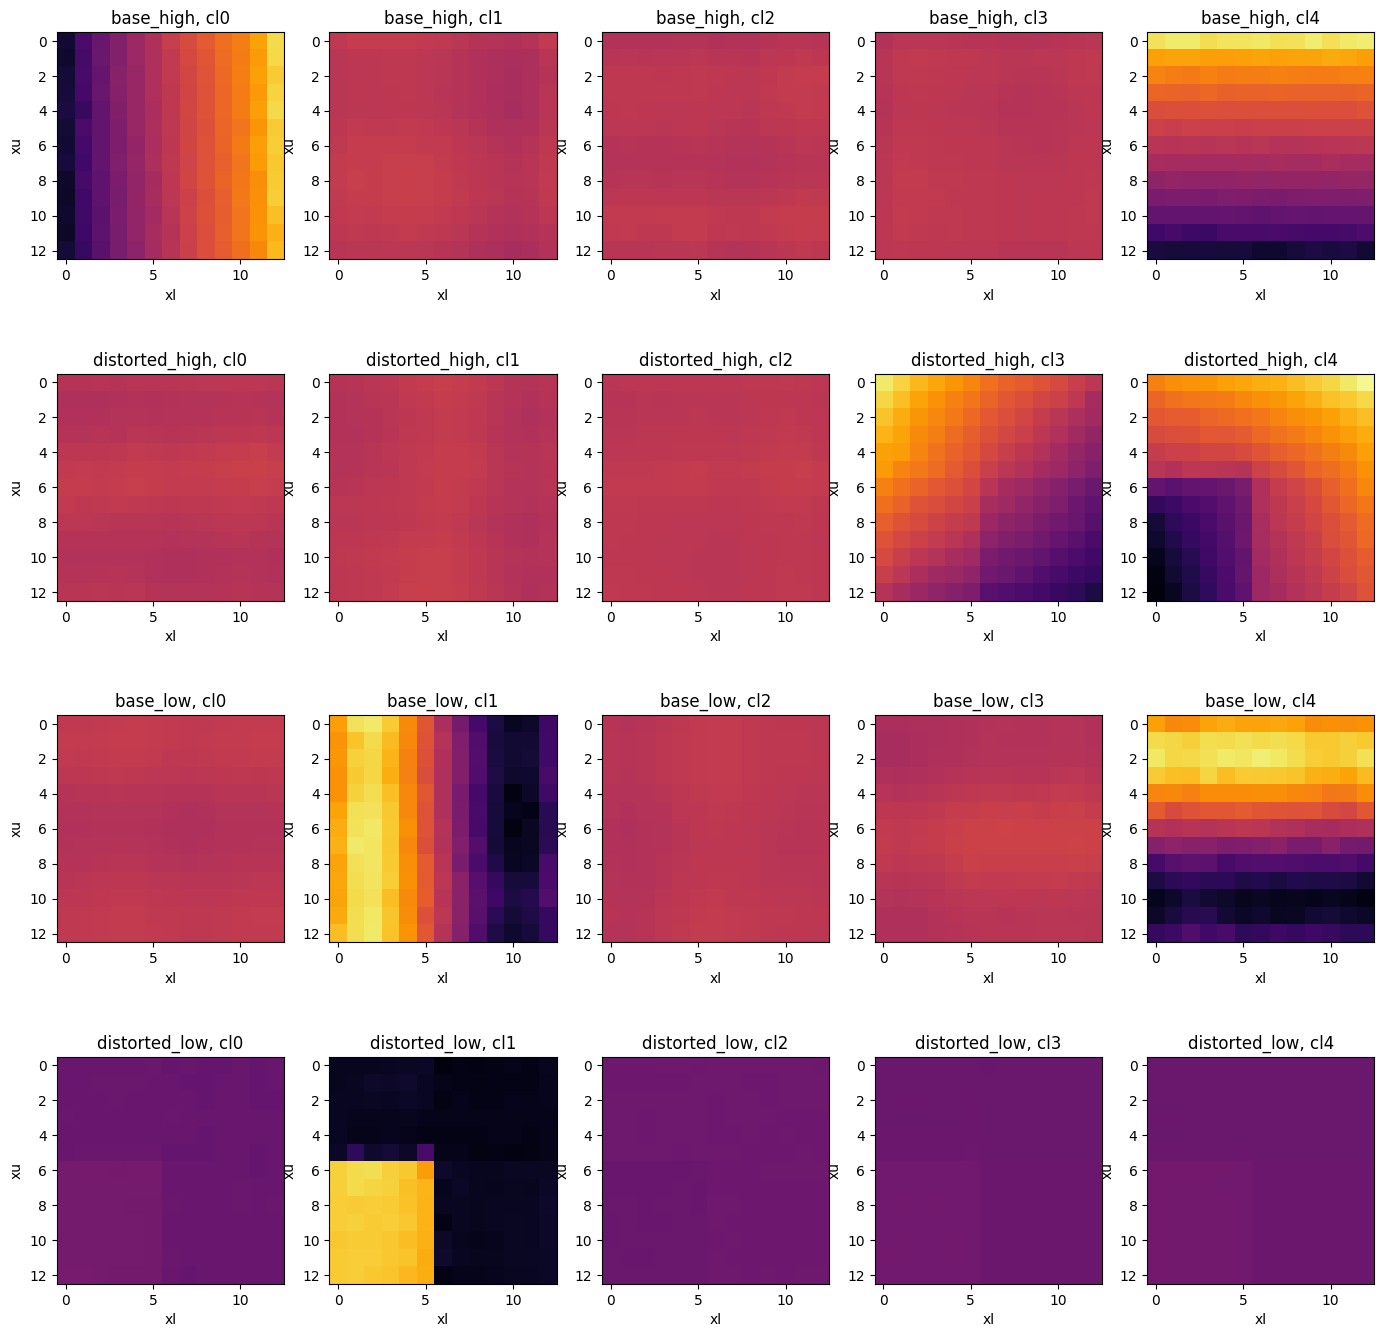

In [5]:
np.random.seed(42)
random.seed(42)
    
task = 'task3'

fig, axs = plt.subplots(4, 5, figsize=(17, 17))
# axs = axs.flatten()
i = 0

for model_name, model_dict in models[task].items():
    
    Z, y = get_encodings(model_dict, idxs, task_num=task)
    df = pd.DataFrame(Z)
    df[['xu', 'xl']] = y
    df = df.groupby(['xu','xl']).mean().reset_index()

    for j in range(Z.shape[1]):
        ax = axs[i, j]

        ax.imshow(
            df.iloc[:,j+2].values.reshape(13,13),
            cmap='inferno',
            vmin=Z.min(),
            vmax=Z.max(),
        )
    
        ax.set_xlabel('xl')
        ax.set_ylabel('xu')

        ax.set_title(model_name+f', cl{j}') 

   
    # # increase font size for labels
    # for item in axs[i].get_yticklabels() + axs[i].get_xticklabels():# + axs[i].get_legend().get_texts():
    #     item.set_fontsize(17)

    # #write a bold letter on every plot
    # axs[i].text(0, 1.01, 1, string.ascii_uppercase[i], transform=axs[i].transAxes, size=25, weight='bold')


    # handles, labels = axs[0].get_legend_handles_labels()

    i += 1
    

fig.show()
fig.savefig(f"../imgs/tuning_curves/{task}.pdf", format='pdf')

In [14]:
from src.utils.loading import load_experiment
import pandas as pd
import torch

def get_new_labels_task0(label):
    if label in [0,1]:
        return 0
    elif label in [2,3,4]:
        return 1
    elif label in [5,6,7]:
        return 2
    elif label in [8,9,10]:
        return 3
    elif label in [11,12]:
        return 4



task = 'task2'
info = {}
info[task] = {}

for model_name, model_dict in models[task].items():
    dataset, model, config = load_experiment(
        model_dict['config'], 
        model_dict['ckpt'], 
        data_path=model_dict['data_path']
    )
    X, y = dataset[idxs]
    X = X.detach().numpy()
    y = y.detach().numpy()

    df = pd.DataFrame(X.reshape(-1, 169))
    df[['y0', 'y1']] = y
    df['diff'] = df.y0 - df.y1
    df.sort_values(by=['diff'], inplace=True, ascending=False)
    y_original = y.copy()

    if int(task[-1])==0:
        labels = np.vectorize(get_new_labels_task0)(y)
        y = labels[:,0]*5 + labels[:,1]
    elif int(task[-1])==1:
        condition = y[:,0] == y[:,1]         
    elif int(task[-1])==2:
        condition = y[:,0] <= y[:,1]
    elif int(task[-1])==3:
        condition = (y[:,0] < 6) | ((y[:,0] >= 6) & (y[:,1] >= 6)) 

    try:
        y = np.where(condition, 1, 0)
    except:
        pass

    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')

    df['clf_label'] = y
    df.sort_values(by=['clf_label'], inplace=True, ascending=True)
    df.drop(columns=['clf_label'], inplace=True)
    X = df.iloc[:,:-3].values.reshape(-1, 1, 13, 13)
    X = torch.tensor(X, dtype=torch.float32)
    #y = df.iloc[:,-3:].values
    #y
    model.to(device)
    model.eval()
    mu, logvar = model.encode(X.to(device))
    #Z = model.reparameterize(mu, logvar).cpu().detach().numpy()
    Z = mu.cpu().detach().numpy()
    
    mds = MDS(n_components=2, random_state=42, n_jobs=8)
    emb = mds.fit_transform(Z)

    info[task]['X'] = X
    info[task]['y'] = y
    info[task]['label'] = y_original
    info[task][model_name] = {
        'Z': Z,
        'emb': emb
    }

X = X.detach().numpy()
mds = MDS(n_components=2, random_state=42, n_jobs=8)
emb = mds.fit_transform(X.reshape(-1, 169))
info[task]['emb'] = emb

/home/leo/.python-envs/bvae-env/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/leo/.python-envs/bvae-env/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/leo/.python-envs/bvae-env/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/leo/.python-envs/bvae-env/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'

In [15]:
info[task]['y']

array([1, 1, 1, ..., 0, 0, 0])

In [6]:
info[task].keys()

dict_keys(['X', 'y', 'label', 'base_high', 'distorted_high', 'base_low', 'distorted_low', 'emb'])

In [30]:
Z = info[task]['base_high']['Z']
U, S, V = np.linalg.svd(Z, full_matrices=False)
S

array([40.331116 , 38.70161  ,  3.25935  ,  2.3004215,  1.0879847],
      dtype=float32)

In [96]:
np.dot(np.diag(S), V).shape

(5, 5)

In [99]:
S[1:] = 0
np.dot(U, np.dot(np.diag(S), V))

array([[ 1.2648963 , -0.0808864 , -0.01974769, -0.03814424,  2.3942413 ],
       [ 1.2811416 , -0.08192524, -0.02000131, -0.03863413,  2.4249911 ],
       [ 1.2208453 , -0.07806948, -0.01905996, -0.03681584,  2.3108602 ],
       ...,
       [-1.1312828 ,  0.07234221,  0.0176617 ,  0.03411499, -2.1413329 ],
       [-1.0261896 ,  0.06562181,  0.01602097,  0.03094579, -1.9424086 ],
       [-1.1719217 ,  0.07494095,  0.01829616,  0.0353405 , -2.2182558 ]],
      dtype=float32)

In [100]:
Z

array([[ 1.8503287e+00,  5.5808827e-02, -5.2691843e-02, -1.8453829e-02,
         2.0896130e+00],
       [ 1.9283568e+00,  8.7333873e-02, -6.1365467e-02, -1.0892297e-02,
         2.0888813e+00],
       [ 1.7935873e+00,  5.7473481e-02, -5.0522789e-02, -1.5457300e-02,
         2.0129361e+00],
       ...,
       [-1.7674441e+00, -2.8884619e-02, -2.9356662e-02, -1.1028619e-03,
        -1.8096125e+00],
       [-1.7708768e+00,  1.6255930e-02, -5.1107761e-02,  7.3060831e-03,
        -1.5515827e+00],
       [-1.8203173e+00, -5.0515659e-02, -1.0457389e-01, -4.9952336e-02,
        -1.8823141e+00]], dtype=float32)

In [83]:
Z = models['task3']['distorted_high']['Z']
U, S, V = np.linalg.svd(Z)
S

array([47.088047 , 36.61644  ,  4.774439 ,  3.650345 ,  0.8487169],
      dtype=float32)

In [82]:
Z = info[task]['distorted_high']['Z']
U, S, V = np.linalg.svd(Z)
S

array([60.894196 , 44.80178  ,  7.8218827,  2.6209354,  1.4883573],
      dtype=float32)

In [75]:
Z = info[task]['base_low']['Z']
U, S, V = np.linalg.svd(Z)
S

array([19.208548  , 18.697208  ,  1.6452067 ,  0.63686454,  0.27529317],
      dtype=float32)

In [76]:
Z = info[task]['distorted_low']['Z']
U, S, V = np.linalg.svd(Z)
S

array([25.83565   ,  0.24967137,  0.19988301,  0.15974538,  0.09740691],
      dtype=float32)

In [ ]:
R = np.dot(Z, V)
R

array([[-0.34287286,  0.5032955 ,  0.05897487, -0.23851775, -0.2668539 ],
       [-0.32958478,  0.40302563,  0.05238387, -0.22831893, -0.22640564],
       [-0.3122321 ,  0.44688088,  0.05406702, -0.21937288, -0.23951225],
       ...,
       [ 0.4395043 , -0.4762874 , -0.18023376,  0.30317926,  0.19265854],
       [ 0.31382135, -0.512384  , -0.13597499,  0.23671423,  0.21877433],
       [ 0.3148903 , -0.41386938, -0.13734429,  0.2243875 ,  0.17480077]],
      dtype=float32)

/tmp/ipykernel_2423469/1507813841.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(R[:,1], R[:,2], cmap='Pastel2')


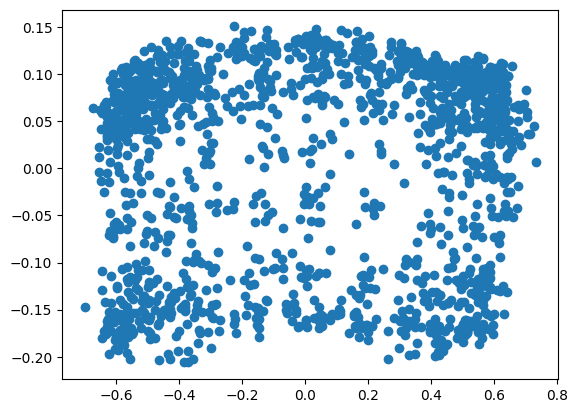

In [ ]:
plt.scatter(R[:,1], R[:,2], cmap='Pastel2')

<Axes: >

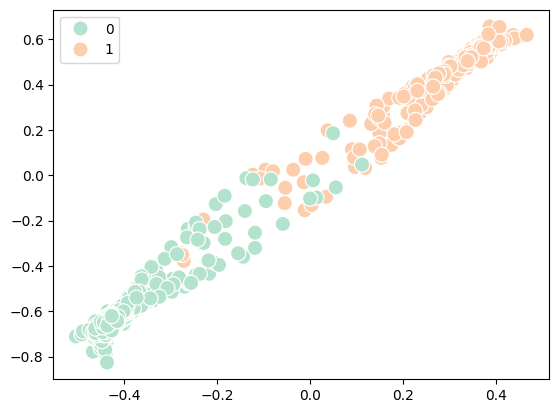

In [36]:
model = 'distorted_low'
sns.scatterplot(x=info[task][model]['emb'][:,0], y=info[task][model]['emb'][:,1], hue=info[task]['y'], palette='Pastel2', s=120)

In [114]:
df.iloc[0,2]= 2000
df.iloc[5,2]= 2000
df.iloc[14,2]= 2000

In [115]:
df.iloc[:,2].values.reshape(13,13)


array([[ 2.00000000e+03, -1.30548263e+00, -8.96351933e-01,
        -6.25371933e-01, -3.60283107e-01,  2.00000000e+03,
         1.28997132e-01,  3.52363944e-01,  5.65356016e-01,
         7.84004688e-01,  9.78252888e-01,  1.27512014e+00,
         1.66829586e+00],
       [-1.88655341e+00,  2.00000000e+03, -9.26816225e-01,
        -6.38815105e-01, -3.37789744e-01, -1.23147234e-01,
         1.04036890e-01,  3.23782653e-01,  5.07004261e-01,
         7.56134927e-01,  1.00238311e+00,  1.29725039e+00,
         1.68565035e+00],
       [-1.82827234e+00, -1.30556190e+00, -9.36487854e-01,
        -6.25990272e-01, -4.05530840e-01, -1.50189623e-01,
         4.68321741e-02,  2.88859159e-01,  4.97511923e-01,
         7.60614514e-01,  1.01249170e+00,  1.30265999e+00,
         1.73046958e+00],
       [-1.74484670e+00, -1.42510307e+00, -9.75848854e-01,
        -6.32461965e-01, -4.00396734e-01, -1.60176218e-01,
         6.42900094e-02,  2.83159852e-01,  4.99583900e-01,
         7.41795778e-01,  1.01763332e

In [116]:
df.head(50)

xu  xl            0         1         2         3         4
0    0   0  2000.000000  0.046536 -0.107718 -0.110538  1.869529
1    0   1    -1.305483  0.078517 -0.080028  0.004907  1.811874
2    0   2    -0.896352  0.079379 -0.089797 -0.002441  1.885379
3    0   3    -0.625372  0.091861 -0.089138 -0.008416  1.825089
4    0   4    -0.360283  0.118970 -0.082522 -0.004986  1.775698
5    0   5  2000.000000  0.078641 -0.091747 -0.048314  1.927308
6    0   6     0.128997  0.039464 -0.103735 -0.049507  1.933008
7    0   7     0.352364 -0.032136 -0.088716 -0.048700  1.794136
8    0   8     0.565356 -0.062837 -0.104453 -0.074298  1.874637
9    0   9     0.784005 -0.080292 -0.083400 -0.070488  1.971824
10   0  10     0.978253 -0.151450 -0.032692 -0.026959  1.797087
11   0  11     1.275120 -0.075503 -0.034209 -0.039544  1.968547
12   0  12     1.668296  0.017063 -0.041990 -0.012085  1.979524
13   1   0    -1.886553 -0.016277 -0.038912 -0.032720  1.327555
14   1   1  2000.000000  0.015759 -0.028934  0.048406  1.359354
15   1   2    -0.926816  0.016553 -0.031454  0.059555  1.317050
16   1   3    -0.638815  0.048586 -0.055999  0.036067  1.473129
17   1   4    -0.337790  0.042597 -0.020027  0.046962  1.354435
18   1   5    -0.123147 -0.008977  0.005875  0.026482  1.299657
19   1   6     0.104037 -0.025836 -0.009849  0.010277  1.273789
20   1   7     0.323783 -0.065850 -0.044092 -0.019227  1.300827
21   1   8     0.507004 -0.103537 -0.050311 -0.017900  1.423713
22   1   9     0.756135 -0.171748 -0.005635 -0.009136  1.313499
23   1  10     1.002383 -0.208576  0.041167  0.011099  1.278644
24   1  11     1.297250 -0.157729  0.040282  0.041878  1.367303
25   1  12     1.685650 -0.073451  0.040426  0.061389  1.345017
26   2   0    -1.828272 -0.011941  0.064604 -0.021506  0.929836
27   2   1    -1.305562  0.006356  0.042974  0.054526  0.932557
28   2   2    -0.936488  0.003168  0.034820  0.055467  0.996541
29   2   3    -0.625990  0.023630  0.028754  0.035298  0.957867
30   2   4    -0.405531  0.041666  0.036834  0.030106  0.985590
31   2   5    -0.150190  0.005632  0.042558  0.011007  0.977471
32   2   6     0.046832 -0.020617  0.037334  0.009497  0.975718
33   2   7     0.288859 -0.069187  0.027979 -0.019738  0.968652
34   2   8     0.497512 -0.126568  0.010848 -0.025922  1.024936
35   2   9     0.760615 -0.192527  0.069653 -0.025108  0.961191
36   2  10     1.012492 -0.201341  0.095373 -0.008787  0.975455
37   2  11     1.302660 -0.171032  0.107361  0.029573  0.992386
38   2  12     1.730470 -0.068505  0.099493  0.056310  1.025316
39   3   0    -1.744847 -0.007470  0.055161 -0.023503  0.633531
40   3   1    -1.425103  0.007030  0.028415  0.007325  0.652138
41   3   2    -0.975849 -0.004547  0.038629  0.046152  0.687373
42   3   3    -0.632462  0.013445  0.022287  0.007809  0.698322
43   3   4    -0.400397  0.037393  0.040803  0.010601  0.688420
44   3   5    -0.160176  0.010025  0.037111 -0.017298  0.654957
45   3   6     0.064290 -0.027839  0.024003 -0.020501  0.666290
46   3   7     0.283160 -0.073032  0.009813 -0.052512  0.664997
47   3   8     0.499584 -0.133839  0.013146 -0.060996  0.663866
48   3   9     0.741796 -0.186248  0.048243 -0.047937  0.659886
49   3  10     1.017633 -0.207637  0.081740 -0.024987  0.687698

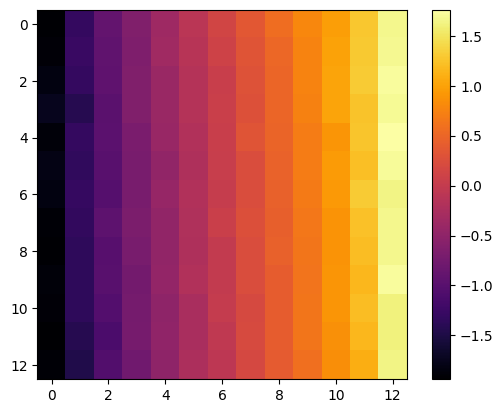

In [120]:
plt.imshow(
    df.iloc[:,2].values.reshape(13,13),
    cmap='inferno',
    # vmin=Z.min(),
    # vmax=Z.max(),

)

#colorbar
cbar = plt.colorbar()

### Measures of distortion

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from matplotlib import colors

task = 'task2'
Z1 = info[task]['base_high']['Z']
Z2 = info[task]['distorted_high']['Z']

mms = MinMaxScaler()
Z1 = mms.fit_transform(Z1)
Z2 = mms.fit_transform(Z2)

def get_dist_ratio(Z1, Z2, **kwargs):
    dist1 = pairwise_distances(Z1, **kwargs)
    dist2 = pairwise_distances(Z2, **kwargs)
    return np.divide(dist1, dist2)

ro = get_dist_ratio(Z2, Z1, metric='euclidean', n_jobs=50)
#fill nan values with 1
ro[np.isnan(ro)] = 1

/tmp/ipykernel_240033/1093801776.py:16: RuntimeWarning: invalid value encountered in divide
  return np.divide(dist1, dist2)


In [23]:
print(
    f'mean: {ro.mean()}\n',
    f'std: {ro.std()}\n',
    f'min: {ro.min()}\n',
    f'max: {ro.max()}\n',
    f'median: {np.median(ro)}\n',
    f'1%: {np.quantile(ro, .01)}\n',
    f'5%: {np.quantile(ro, .05)}\n',
    f'25%: {np.quantile(ro, .25)}\n',
    f'75%: {np.quantile(ro, .75)}\n',
    f'95%: {np.quantile(ro, .95)}\n',
    f'99%: {np.quantile(ro, .99)}\n',
)

mean: 1.0276103019714355
 std: 0.4034646451473236
 min: 0.054034970700740814
 max: 12.542778968811035
 median: 0.9479472637176514
 1%: 0.3985091745853424
 5%: 0.5651036500930786
 25%: 0.7878377437591553
 75%: 1.1702557802200317
 95%: 1.7415452003479004
 99%: 2.5235283374786377



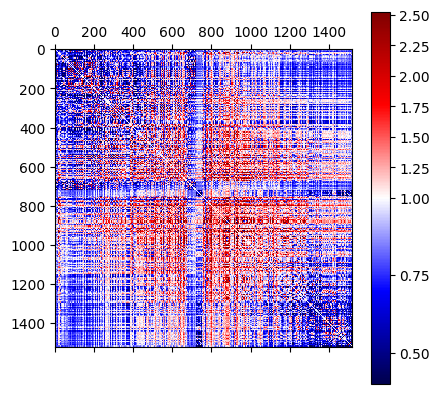

In [24]:
divnorm = colors.TwoSlopeNorm(vmin=np.quantile(ro, .01), vcenter=1, vmax=np.quantile(ro, .99))
#divnorm = colors.TwoSlopeNorm(vmin=-range_ext, vcenter=0, vmax=range_ext)

plt.matshow(
    ro,
    cmap='seismic',
    norm=divnorm
)
plt.colorbar()

In [25]:
df

0    1    2    3    4    5    6    7    8    9  ...  162  163  164  \
34    0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
33    1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
30    0.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  0.0   
25    0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  0.0   
26    1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1510  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
1514  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
1515  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
1512  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
1511  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   

      165  166  167  168  y0  y1  diff  
34    0.0  0.0  0.0  1.0   0  10   -10  
33    1.0  0.0  0.0  0.0   2  12   -10  
30    0.0  0.0  0.0  1.0   0  10   -10  
25    0.0  0.0  0.0  0.0   0  10   -10  
26    0.0  0.0  1.0  0.0   2  12   -10  
...   ...  ...  ...  ...  ..  ..   ...  
1510  1.0  1.0  1.0  1.0  12   0    12  
1514  1.0  1.0  1.0  1.0  12   0    12  
1515  1.0  1.0  1.0  1.0  12   0    12  
1512  1.0  1.0  1.0  1.0  12   0    12  
1511  1.0  1.0  1.0  1.0  12   0    12  

[1521 rows x 172 columns]

In [ ]:
range_ext = 3
divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1+range_ext)

plt.matshow(
    ro,
    cmap='seismic',
    norm=divnorm
)
plt.colorbar()

<Axes: >

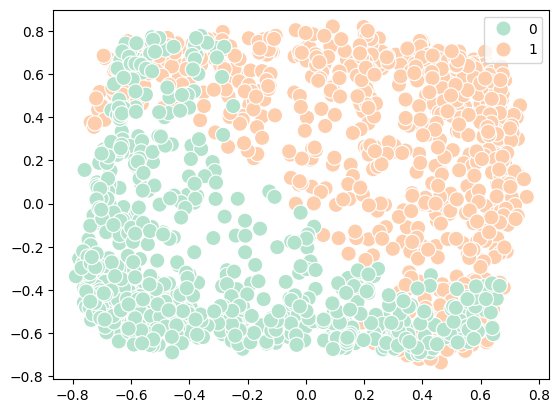

In [11]:
model = 'base_low'
sns.scatterplot(x=info[task][model]['emb'][:,0], y=info[task][model]['emb'][:,1], hue=info[task]['y'], palette='Pastel2', s=120)

In [168]:
Z1

array([[0.88287425, 0.50009924, 0.62448394, 0.35268655, 0.9465384 ],
       [0.9432039 , 0.2361348 , 0.7448553 , 0.41404068, 0.8963234 ],
       [0.95386493, 0.4611839 , 0.8109388 , 0.51310873, 0.9368874 ],
       ...,
       [0.07393298, 0.2549991 , 0.5891925 , 0.649492  , 0.07267413],
       [0.06670162, 0.3183822 , 0.4221574 , 0.6661945 , 0.050448  ],
       [0.08887857, 0.09081501, 0.48597187, 0.5087029 , 0.06470636]],
      dtype=float32)

<Axes: >

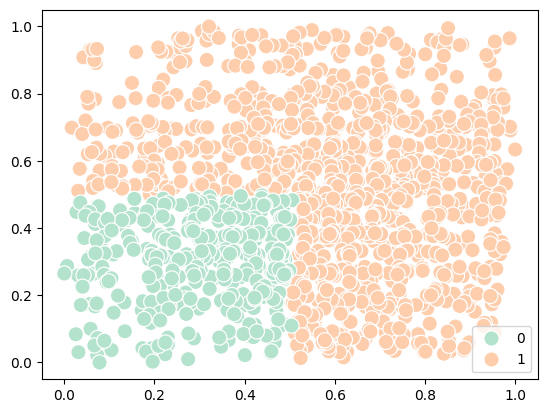

In [171]:
task = 'task3'
Z1 = info[task]['base_high']['Z']
Z2 = info[task]['distorted_high']['Z']

mms = MinMaxScaler()
Z1 = mms.fit_transform(Z1)
Z2 = mms.fit_transform(Z2)

sns.scatterplot(x=Z1[:,0], y=Z1[:,4], hue=info[task]['y'], palette='Pastel2', s=120)

In [173]:
Z2

array([[0.44718322, 0.4838061 , 0.6140493 , 0.47670686, 0.9592545 ],
       [0.45405364, 0.15843329, 0.23919576, 0.4517501 , 0.98139894],
       [0.6939294 , 0.5582556 , 0.42669362, 0.46637967, 0.9968274 ],
       ...,
       [0.59146714, 0.60244876, 0.5854371 , 0.4338726 , 0.0273658 ],
       [0.54790425, 0.65542793, 0.7525898 , 0.45607868, 0.00750011],
       [0.5133103 , 0.394652  , 0.6168827 , 0.41280606, 0.03771323]],
      dtype=float32)

<Axes: >

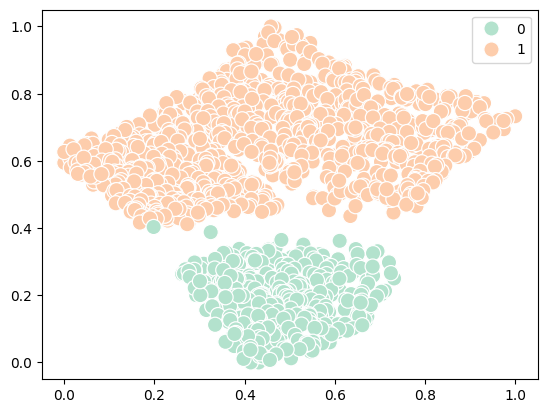

In [174]:
sns.scatterplot(x=Z2[:,3], y=Z2[:,4], hue=info[task]['y'], palette='Pastel2', s=120)

In [2]:
import sys
sys.path.append("..")

# from src.utils.out_processing import Results, BaseContainer

import pickle
pickle.load(open('processed/clf_latent_results.pkl', 'rb'))

## Measures of distortion

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import product


task = 'task1'
capacity = 'high'

mc_base = r.base.__getattribute__(capacity) #model container
mc_dist = r.__getattribute__(task).__getattribute__(capacity) #model container

Z1 =mc_base.emb
Z2 = mc_dist.emb

# mms = MinMaxScaler()
# Z1 = mms.fit_transform(Z1)
# Z2 = mms.fit_transform(Z2)

def get_dist_ratio(Z1, Z2, **kwargs):
    dist1 = pairwise_distances(Z1, **kwargs)
    dist2 = pairwise_distances(Z2, **kwargs)
    return np.divide(dist1, dist2)

ro = get_dist_ratio(Z2, Z1, metric='euclidean', n_jobs=50)
#fill nan values with 1
ro[np.isnan(ro)] = 1

print(
    f'mean: {ro.mean()}\n',
    f'std: {ro.std()}\n',
    f'min: {ro.min()}\n',
    f'max: {ro.max()}\n',
    f'median: {np.median(ro)}\n',
    f'1%: {np.quantile(ro, .01)}\n',
    f'5%: {np.quantile(ro, .05)}\n',
    f'25%: {np.quantile(ro, .25)}\n',
    f'75%: {np.quantile(ro, .75)}\n',
    f'95%: {np.quantile(ro, .95)}\n',
    f'99%: {np.quantile(ro, .99)}\n',
)

/tmp/ipykernel_364587/2253064801.py:28: RuntimeWarning: invalid value encountered in divide
  return np.divide(dist1, dist2)


mean: 1.2781024411821231
 std: 0.9272815866220816
 min: 0.00820801974333925
 max: 688.9982831581616
 median: 1.2189823875262966
 1%: 0.36080285985593097
 5%: 0.6184555771624626
 25%: 1.0081544729876735
 75%: 1.421714922166352
 95%: 2.0611374090803043
 99%: 3.387769169378652



In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
from itertools import product

def get_class_dist_matrix(Z_dist, Z_base, labels, **kwargs):
    dist1 = pairwise_distances(Z_dist, metric='euclidean', **kwargs)
    dist2 = pairwise_distances(Z_base, metric='euclidean', **kwargs)
    ro = np.divide(dist1, dist2)

    A = np.empty((2,2))

    #0-1
    sel0 = list(np.where(labels == 0)[0])
    sel1 = list(np.where(labels == 1)[0])
    sel = [*product(sel0, sel1)]
    l = []
    for i, j in sel:
        l.append(ro[i,j])
    A[0,1] = A[1,0] = (pd.Series(l) - ro.mean()).mean()
    
    #0-0
    sel = list(np.where(labels == 0)[0])
    sel = [*product(sel, sel)]
    l = []
    for i, j in sel:
        l.append(ro[i,j])
    A[0,0] = (pd.Series(l)-ro.mean()).mean()

    #1-1
    sel = list(np.where(labels == 1)[0])
    sel = [*product(sel, sel)]
    l = []
    for i, j in sel:
        l.append(ro[i,j])
    A[1,1] = (pd.Series(l)-ro.mean()).mean()
    
    return A

---

In [ ]:
A = np.empty((2,2))

### 0-1

In [ ]:
sel0 = list(np.where(mc_dist.y == 0)[0])
sel1 = list(np.where(mc_dist.y == 1)[0])
sel = [*product(sel0, sel1)]

l = []
for i, j in sel:
    l.append(ro[i,j])

A[0,1] = A[1,0] = (pd.Series(l) - ro.mean()).mean()

### 0-0

In [ ]:

sel = list(np.where(mc_dist.y == 0)[0])
sel = [*product(sel, sel)]

l = []
for i, j in sel:
    l.append(ro[i,j])

A[0,0] = (pd.Series(l)-ro.mean()).mean()

### 1-1

In [ ]:

sel = list(np.where(mc_dist.y == 1)[0])
sel = [*product(sel, sel)]

l = []
for i, j in sel:
    l.append(ro[i,j])

A[1,1] = (pd.Series(l)-ro.mean()).mean()

<Axes: >

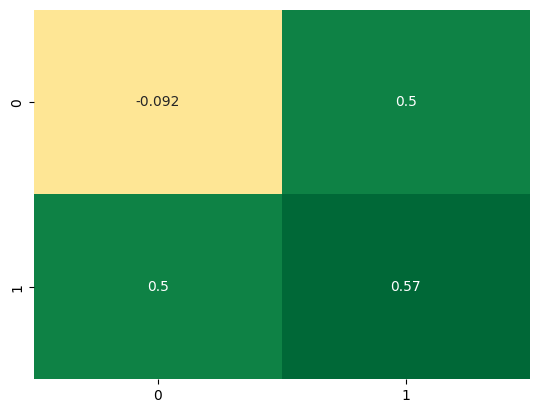

In [ ]:
sns.heatmap(A, annot=True, center=0, cbar=False, cmap='RdYlGn', )

[Text(-200.0, 1, '−200'), Text(0.0, 1, '0'), Text(200.0, 1, '200'), Text(400.0, 1, '400'), Text(600.0, 1, '600'), Text(800.0, 1, '800'), Text(1000.0, 1, '1000'), Text(1200.0, 1, '1200'), Text(1400.0, 1, '1400'), Text(1600.0, 1, '1600')]


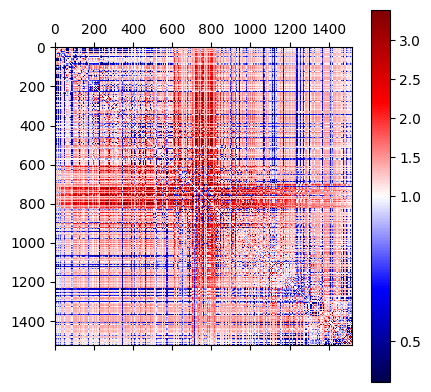

In [ ]:
divnorm = colors.TwoSlopeNorm(vmin=np.quantile(ro, .01), vcenter=1, vmax=np.quantile(ro, .99))
#divnorm = colors.TwoSlopeNorm(vmin=-range_ext, vcenter=0, vmax=range_ext)

plt.matshow(
    ro,
    cmap='seismic',
    norm=divnorm
)

print(
    plt.gca().get_xticklabels()
)

plt.colorbar()

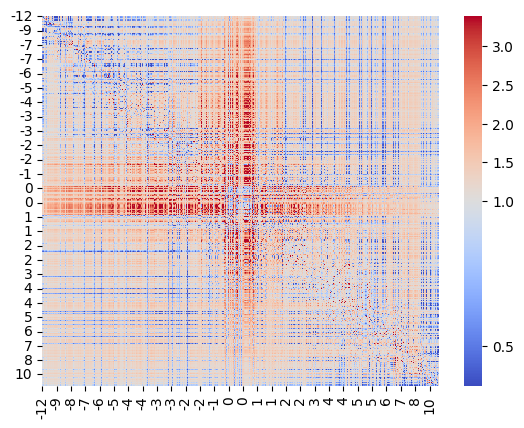

In [ ]:
import seaborn as sns

divnorm = colors.TwoSlopeNorm(vmin=np.quantile(ro, .01), vcenter=1, vmax=np.quantile(ro, .99))
#divnorm = colors.TwoSlopeNorm(vmin=-range_ext, vcenter=0, vmax=range_ext)

ax = sns.heatmap(
    ro,
    cmap='coolwarm',
    norm=divnorm,
)

diff = mc_base.y[:,0] - mc_base.y[:,1]

xticks = ax.get_xticklabels()
new_xticks = [diff[int(x.get_text())] for x in xticks]
ax.set_xticklabels(new_xticks)

yticks = ax.get_yticklabels()
new_yticks = [diff[int(y.get_text())] for y in yticks]
ax.set_yticklabels(new_yticks)
    

plt.show()

#plt.colorbar()